In [2]:
!pip install sage-data-client

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


The Solar Radiations range between 1060.2 and -9.74, resulting in a range of 1069.94
The average Solar Radiation over the course of the summer: 406.4949929840987


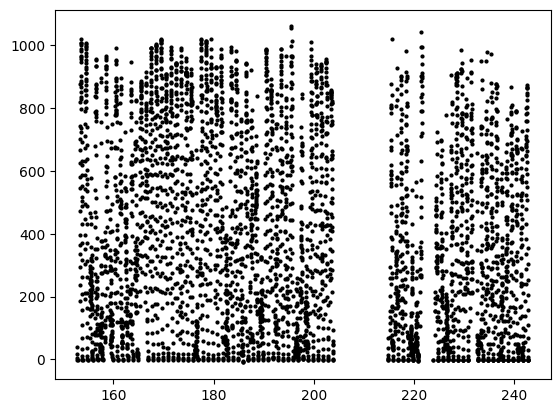

In [25]:
from sqlalchemy.sql.expression import null
from pandas.io.formats.format import DataFrameFormatter
import csv
import sage_data_client
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import models
from datetime import datetime














#Using pandas to preprocess
solar_rad_file = "https://raw.githubusercontent.com/waggle-sensor/summer2023/main/Shen/Data/Solar_Irradiance.csv"

#load in columns
#Data being read is only during the Summer Season



raw_csv_data = pd.read_csv(solar_rad_file)



df=raw_csv_data.copy()


##Remove the times when the sun is not out


def remove_dark_data(dataframe):
  for index, row in dataframe.iterrows():
    time = int(row['T_LST'][0:2] + row['T_LST'][3:5])
    if time < 600 or time > 2000:
      dataframe.drop(index, inplace=True)


remove_dark_data(df)



#Remove excess columns

def remove_columns(dataframe):
  for column_name, column_data in dataframe.items():
    if (column_name != 'T_LST' and column_name != 'JDA' and column_name != 'radW/m2'):
      dataframe.drop(column_name, axis=1, inplace= True)

remove_columns(df)


#Make sure the indices are rest properly


df.reset_index(drop = True, inplace=True)









def find_max(dataframe):
  max = -99999
  for index, row in dataframe.iterrows():
      if row['radW/m2'] > max:
        max = row['radW/m2']
  return max



def find_min(dataframe):
  min = 99999
  for index, row in dataframe.iterrows():
      if row['radW/m2'] < min:
        min = row['radW/m2']
  return min



def find_mean(dataframe):
  total = 0
  for index, row in dataframe.iterrows():
      total += row['radW/m2']
  return total/len(dataframe)




#maximum
max_solar_rad = find_max(df)

#minimum
min_solar_rad = find_min(df)

#range
range2 = max_solar_rad - min_solar_rad
print(f"The Solar Radiations range between {max_solar_rad} and {min_solar_rad}, resulting in a range of {range2}")

#mean
mean = find_mean(df)
print(f"The average Solar Radiation over the course of the summer: {mean}")




#convert the times to Decimal values to plot the graph in a logical manner
Day_Times_Combo = []
for index, row in df.iterrows():
    time = int(row['T_LST'][0:2] + row['T_LST'][3:5])
    real_time = float(time/2400)
    day = row['JDA']
    combo = day + real_time
    Day_Times_Combo.append(combo)



## Plot of radiations over the whole summer
## There is a whole in Day 205 because no Data was collected
def plot():

  x_data = Day_Times_Combo
  y_data = []
  for index, row in df.iterrows():
      y_data.append(row['radW/m2'])
  x = np.array(x_data)
  y= np.array(y_data)


  plt.plot(x, y, 'o', color='black', markersize = 2);

##Uncomment to Show Plot
plot()










In [26]:
#To see the Data
print(df)

      JDA  T_LST  radW/m2
0     152  19:00    41.13
1     152  19:15    16.71
2     152  19:30     4.22
3     152  19:45    -0.42
4     152  20:00    -0.67
...   ...    ...      ...
4271  242  19:00    -1.97
4272  242  19:15    -1.87
4273  242  19:30    -1.88
4274  242  19:45    -1.71
4275  242  20:00    -1.90

[4276 rows x 3 columns]


In [27]:

###Images

#1. Remove the data that are earlier than 7AM and later than 7PM  :: Done

#2. Iterate through the list and calculate whichever values are closest to the each 15 minute mark :: Done

#3. Do this for Data from June, July, and August, and Combine the overall data to match the Solar Irradiance :: Done






##Remove all the images that were taken before 7AM or after 7PM

def remove_dark_data_im(dataframe):
    # Create a new series with the time as a numerical value
    time = dataframe['timestamp'].apply(lambda x: 100 * x.time().hour + x.time().minute)
    mask = (time >= 600) & (time <= 2000)
    dataframe = dataframe[mask]
    return dataframe




##Choose the images for each 15 minute interval

def choose_image_interval(dataframe):
  # Ensure that 'timestamp' is of type datetime
  dataframe2 = dataframe.copy()
  dataframe2['timestamp'] = pd.to_datetime(dataframe2['timestamp'])
  dataframe2 = dataframe2.set_index('timestamp')
  resampled_df = dataframe2.resample('15min').first()
  resampled_df = resampled_df.reset_index()
  return resampled_df





##Clean out the None values that are added from the Interval Function
def clean_nones(dataframe):
  for index, row in dataframe.iterrows():
    if row['meta.job'] != 'sage':
      dataframe.drop(index, inplace= True)





##################

#June


#Load In all Data for Images in June

df_im_june = sage_data_client.query(
    start="2022-06-01T05:00:00.000Z",
    end="2022-07-01T05:00:00.000Z",
    filter={
        "vsn": "W039",
        "task": "imagesampler-top"
    }
)




## Clean the data using functions on month of June
cleaned_df_im_june = choose_image_interval(remove_dark_data_im(df_im_june))
clean_nones(cleaned_df_im_june)



#### Test whether the data was cleaned, June

#for index, row in cleaned_df_im_june.iterrows():
  #print(row['timestamp'])

####






##################

#July



#Load In all Data for Images in July

df_im_july = sage_data_client.query(
    start="2022-07-01T05:00:00.000Z",
    end="2022-07-31T05:00:00.000Z",
    filter={
        "vsn": "W039",
        "task": "imagesampler-top"
    }
)


cleaned_df_im_july = choose_image_interval(remove_dark_data_im(df_im_july))
clean_nones(cleaned_df_im_july)

for index, row in cleaned_df_im_july.iterrows():
  converted_date = (datetime.date(row['timestamp']))
  if converted_date.day == 23:
    cleaned_df_im_july.drop(index, inplace= True)




####

#Test whether the data was cleaned, July



#for index, row in cleaned_df_im_july.iterrows():
  #print(row['timestamp'])



####


##################

#August



#Load in all Image Data for August
df_im_aug = sage_data_client.query(
    start="2022-08-01T05:00:00.000Z",
    end="2022-08-31T05:00:00.000Z",
    filter={
        "vsn": "W039",
        "task": "imagesampler-top"
    }
)

cleaned_df_im_aug = choose_image_interval(remove_dark_data_im(df_im_aug))
clean_nones(cleaned_df_im_aug)

#### Test whether the data was cleaned, August

#for index, row in cleaned_df_im_aug.iterrows():
  #print(row['timestamp'])

####


##################



#Combine all three data frames

dataframes = [cleaned_df_im_june, cleaned_df_im_july, cleaned_df_im_aug]

all_cleaned_df_im = pd.concat(dataframes)


###

#Test Date Order


#for index, row in all_cleaned_df_im.iterrows():
  #print(row['timestamp'])



###





##################







                     timestamp    name  \
0    2022-06-01 19:00:00+00:00  upload   
1    2022-06-01 19:15:00+00:00  upload   
2    2022-06-01 19:30:00+00:00  upload   
3    2022-06-01 19:45:00+00:00  upload   
4    2022-06-01 20:00:00+00:00  upload   
...                        ...     ...   
2690 2022-08-30 19:00:00+00:00  upload   
2691 2022-08-30 19:15:00+00:00  upload   
2692 2022-08-30 19:30:00+00:00  upload   
2693 2022-08-30 19:45:00+00:00  upload   
2694 2022-08-30 20:00:00+00:00  upload   

                                                  value meta.filename  \
0     https://storage.sagecontinuum.org/api/v1/data/...    sample.jpg   
1     https://storage.sagecontinuum.org/api/v1/data/...    sample.jpg   
2     https://storage.sagecontinuum.org/api/v1/data/...    sample.jpg   
3     https://storage.sagecontinuum.org/api/v1/data/...    sample.jpg   
4     https://storage.sagecontinuum.org/api/v1/data/...    sample.jpg   
...                                                 ...  

In [57]:
##Final cleaning of the dataframes

all_cleaned_df_im = pd.concat(dataframes)


all_cleaned_df_im.reset_index(drop = True, inplace= True)
all_cleaned_df_im.drop(18, inplace= True)
all_cleaned_df_im.reset_index(drop = True, inplace= True)
all_cleaned_df_im.drop(248, inplace= True)
all_cleaned_df_im.reset_index(drop = True, inplace= True)
all_cleaned_df_im.drop(270, inplace= True)
all_cleaned_df_im.reset_index(drop = True, inplace= True)
all_cleaned_df_im.drop(309, inplace= True)
all_cleaned_df_im.reset_index(drop = True, inplace= True)
all_cleaned_df_im.drop(1069, inplace= True)
all_cleaned_df_im.reset_index(drop = True, inplace= True)
all_cleaned_df_im.drop(1069, inplace= True)
all_cleaned_df_im.reset_index(drop = True, inplace= True)
all_cleaned_df_im.drop(1069, inplace= True)
all_cleaned_df_im.reset_index(drop = True, inplace= True)
all_cleaned_df_im.drop(1069, inplace= True)
all_cleaned_df_im.reset_index(drop = True, inplace= True)
all_cleaned_df_im.drop(2269, inplace= True)
all_cleaned_df_im.reset_index(drop = True, inplace= True)
all_cleaned_df_im.drop(2640, inplace= True)
all_cleaned_df_im.reset_index(drop = True, inplace= True)










##Algorithm to identify differences in dates betweeen the two dataframe,
##To ensure each image is properly matching up to the correct solar irradiation measurement
"""

x= 0


while x < 4276:
  image_time = datetime.time(all_cleaned_df_im.at[x,'timestamp'])
  data_time = datetime.strptime((df.at[x, 'T_LST']), '%H:%M').time()
  print("This is the image date: ")
  print(all_cleaned_df_im.at[x,'timestamp'])
  print("\n")
  print("This is the data date: ")
  print(data_time)
  print("\n")
  if image_time != data_time:
    print(x)
    break
  x+=1

"""






'\n\nx= 0\n\n\nwhile x < 4276:\n  image_time = datetime.time(all_cleaned_df_im.at[x,\'timestamp\'])\n  data_time = datetime.strptime((df.at[x, \'T_LST\']), \'%H:%M\').time()\n  print("This is the image date: ")\n  print(all_cleaned_df_im.at[x,\'timestamp\'])\n  print("\n")\n  print("This is the data date: ")\n  print(data_time)\n  print("\n")\n  if image_time != data_time:\n    print(x)\n    break\n  x+=1\n\n'

In [58]:
#Display the Final Cleaned Image Data


#for index,row in all_cleaned_df_im.iterrows():
  #print(row['value'])


print(all_cleaned_df_im)

                     timestamp    name  \
0    2022-06-01 19:00:00+00:00  upload   
1    2022-06-01 19:15:00+00:00  upload   
2    2022-06-01 19:30:00+00:00  upload   
3    2022-06-01 19:45:00+00:00  upload   
4    2022-06-01 20:00:00+00:00  upload   
...                        ...     ...   
4271 2022-08-30 19:00:00+00:00  upload   
4272 2022-08-30 19:15:00+00:00  upload   
4273 2022-08-30 19:30:00+00:00  upload   
4274 2022-08-30 19:45:00+00:00  upload   
4275 2022-08-30 20:00:00+00:00  upload   

                                                  value meta.filename  \
0     https://storage.sagecontinuum.org/api/v1/data/...    sample.jpg   
1     https://storage.sagecontinuum.org/api/v1/data/...    sample.jpg   
2     https://storage.sagecontinuum.org/api/v1/data/...    sample.jpg   
3     https://storage.sagecontinuum.org/api/v1/data/...    sample.jpg   
4     https://storage.sagecontinuum.org/api/v1/data/...    sample.jpg   
...                                                 ...  

In [61]:
##Sorting the images and Data into Classes
from google.colab import drive


#drive.mount('/content/drive')


#1 Remove unecessary data in both data sets so I can sort easier


for column_name, column_data in all_cleaned_df_im.items():
  if (column_name != 'value'):
    all_cleaned_df_im.drop(column_name, axis=1, inplace= True)

#print(all_cleaned_df_im)


for column_name, column_data in df.items():
  if (column_name != 'radW/m2'):
    df.drop(column_name, axis=1, inplace= True)

#print(df)




#2 Combine both data sets
completed_df = pd.concat([all_cleaned_df_im, df], axis=1)

#print(completed_df)




#3 Remove negative values from the data set
for index, row in completed_df.iterrows():
  irradiance = row['radW/m2']
  if irradiance < 0:
    completed_df.drop(index, inplace= True)

completed_df.reset_index(drop = True, inplace= True)

#count = 0
#for index, row in completed_df.iterrows():
  #if row['radW/m2'] > 1000:
    #print(row['radW/m2'])
    #count+=1
#print(count)



#print(completed_df)





#4 Put the images into classes through Google drive


base_dir = "/content/drive/MyDrive/Base_Directory/"

bins = list(range(0, 1200, 100))  # Bins from 0-1000 by 100


labels = [f'{i}-{i+100}' for i in bins[:-1]]  # creates labels ['0-100', '100-200', ..., '900-1000']

#print(labels)


irradiance = 'radW/m2'
image_path = 'value'


##Make a new column in the Data frame called class, that classifies each image/solarIrradiance value

completed_df['class'] = pd.cut(completed_df[irradiance], bins=bins, labels=labels, include_lowest=True)

#for index, row in completed_df.iterrows():
  #print(row['radW/m2'])
  #print('/')
  #print(row['class'])
  #print('\n')



Streaming output truncated to the last 5000 lines.
47.97
/
0-100


24.66
/
0-100


11.83
/
0-100


12.68
/
0-100


9.92
/
0-100


12.58
/
0-100


11.16
/
0-100


8.6
/
0-100


15.81
/
0-100


15.82
/
0-100


3.02
/
0-100


107.57
/
100-200


150.32
/
100-200


215.44
/
200-300


267.49
/
200-300


265.42
/
200-300


288.92
/
200-300


358.4
/
300-400


345.05
/
300-400


268.98
/
200-300


486.58
/
400-500


372.87
/
300-400


323.41
/
300-400


263.81
/
200-300


334.75
/
300-400


454.86
/
400-500


572.25
/
500-600


517.22
/
500-600


631.97
/
600-700


712.32
/
700-800


836.13
/
800-900


903.44
/
900-1000


996.1
/
900-1000


1041.9
/
1000-1100


791.18
/
700-800


887.23
/
800-900


995.6
/
900-1000


965.69
/
900-1000


941.77
/
900-1000


910.7
/
900-1000


903.45
/
900-1000


896.23
/
800-900


869.25
/
800-900


844.18
/
800-900


818.33
/
800-900


790.12
/
700-800


753.72
/
700-800


719.72
/
700-800


79.26
/
0-100


153.4
/
100-200


195.87
/
100-200


155.06
/
100-200